# Equations in matrix form


We derived these equations:

\begin{align*}
\hat{y}_{R}(\xi) = (W_{R}(\xi) + W_{R}(-\xi)) \sin(\chi) + (W_{I}(\xi) + W_{I}(-\xi)) \cos(\chi) \\
\hat{y}_{I}(\xi) = - (W_{R}(\xi) - W_{R}(-\xi)) \cos(\chi) + (W_{I}(\xi) - W_{I}(-\xi)) \sin(\chi)
\end{align*}


The same ones in matrix form:

\begin{equation}
  \begin{bmatrix}
    y_R \\
    y_I
  \end{bmatrix}
= 
\begin{bmatrix}
  D_1 & D_2 & &\\
  & & D_1 & D_2\\
\end{bmatrix}
\begin{bmatrix}
  I + F & \\
   &  I +F  \\
  -I + F & \\
  &  I -F  \\
\end{bmatrix}
\begin{bmatrix}
  S & \\
  & S \\
\end{bmatrix}
\begin{bmatrix}
  v_R \\
  v_I
\end{bmatrix}
\end{equation}

$S \in \mathbb{R}^{N^2 \times N^3}$ is the sphere slicing matrix, $I$ is the identity, $F \in \mathbb{R}^{N^2 \times N^2}$ is the flipping matrix $D_1$ is the diagonal matrix that does multiplication with $\sin(\chi)$ and $D_2$ with  $\cos(\chi)$. The adjooint operation is thus:


\begin{equation}
\begin{bmatrix}
  \tilde{v}_R \\
  \tilde{v}_I
\end{bmatrix}
= 
\begin{bmatrix}
  S & \\
  & S \\
\end{bmatrix}^T
\begin{bmatrix}
  I + F & \\
   &  I +F  \\
  -I + F & \\
  &  I -F  \\
\end{bmatrix}^T
\begin{bmatrix}
  D_1 & D_2 & &\\
  & & D_1 & D_2\\
\end{bmatrix}^T
  \begin{bmatrix}
    y_R \\
    y_I
  \end{bmatrix} 
\end{equation}

\begin{equation}
= \begin{bmatrix}
  S^T & \\
  & S^T \\
\end{bmatrix}
\begin{bmatrix}
  I + F & & -I + F &  \\
   & I +F & & I -F  \\
\end{bmatrix}
\begin{bmatrix}
  D_1  &\\
  D_2 & \\
  & D_1 \\
  & D_2\\
\end{bmatrix}
  \begin{bmatrix}
    y_R \\
    y_I
  \end{bmatrix}
\end{equation}

where I used that $F, I, D_1, D_2$ are symmetric

In [1]:
import recovar.config
from importlib import reload
import jax 
import jax.numpy as jnp
import numpy as np
from recovar import core, utils, fourier_transform_utils
ftu = fourier_transform_utils.fourier_transform_utils(jax.numpy)
import functools

def get_unrotated_ewald_sphere_coords(image_shape, voxel_size, lam, scaled=True):
    ## Pass scaled = true
    freqs = ftu.get_k_coordinate_of_each_pixel(image_shape, voxel_size=voxel_size, scaled=True)
    r = 1/lam
    z = r - jnp.sqrt(r**2 - jnp.linalg.norm(freqs, axis =-1)**2)
    z = z.reshape(-1,1)
    sphere_freqs = jnp.concatenate([freqs, z], axis=-1)
    scalar = 1 if scaled else image_shape[0] * voxel_size
    return sphere_freqs * scalar


# @functools.partial(jax.jit, static_argnums=[1,2,3])
def get_ewald_sphere_gridpoint_coords(rotation_matrix, image_shape, volume_shape, grid_size, voxel_size, lam):
    unrotated_plane_indices = get_unrotated_ewald_sphere_coords(image_shape, voxel_size, lam, scaled = False)
    
    rotated_plane = jnp.matmul(unrotated_plane_indices, rotation_matrix, precision = jax.lax.Precision.HIGHEST)
    rotated_coords = rotated_plane + jnp.floor(1.0 * grid_size/2)
    # import pdb; pdb.set_trace()
    # rotated_indices = vol_indices_to_vec_indices(rotated_indices, volume_shape)
    # Note I am being very sloppy with out of bound stuff. JAX just ignores them, which is what we want, but this doomed to cause bugs eventually.
    # indices_in_grid = jnp.prod((rotated_indices >= 0 ) * (rotated_indices < grid_size), axis = -1).astype(bool)
    return rotated_coords



batch_get_sphere_gridpoint_coords = jax.vmap(get_ewald_sphere_gridpoint_coords, in_axes =(0, None, None, None, None, None) ) 

def get_ewald_sphere_slices(volume, rotation_matrices, image_shape, volume_shape, grid_size, voxel_size, lam, disc_type):
    order = 1 if disc_type == "linear_interp" else 0
    return map_coordinates_on_ewald_sphere(volume, rotation_matrices, image_shape, volume_shape, grid_size, voxel_size, lam, order)
    

# No reason not to do this for forward model, but haven't figured out how to do it for the adjoint 
def map_coordinates_on_ewald_sphere(volume, rotation_matrices, image_shape, volume_shape, grid_size, voxel_size, lam,  order):
    # import pdb; pdb.set_trace()
    batch_grid_pt_vec_ind_of_images = batch_get_sphere_gridpoint_coords(rotation_matrices, image_shape, volume_shape, grid_size, voxel_size, lam )
    # batch_grid_pt_vec_ind_of_images = core.batch_get_gridpoint_coords(rotation_matrices, image_shape, volume_shape, grid_size )
    batch_grid_pt_vec_ind_of_images_og_shape = batch_grid_pt_vec_ind_of_images.shape
    batch_grid_pt_vec_ind_of_images = batch_grid_pt_vec_ind_of_images.reshape(-1,3).T
    slices = jax.scipy.ndimage.map_coordinates(volume.reshape(volume_shape), batch_grid_pt_vec_ind_of_images, order = order, mode = 'constant', cval = 0.0).reshape(batch_grid_pt_vec_ind_of_images_og_shape[:-1] ).astype(volume.dtype)
    return slices


def get_chi(freqs, dfu, dfv, dfang, volt, cs, w, phase_shift, bfactor):   
    volt = volt * 1000
    cs = cs * 10** 7
    dfang = dfang * jnp.pi/180
    phase_shift = phase_shift * jnp.pi / 180

    # Lambda:
    lam = 12.2639 / (volt + 0.97845e-6 * volt**2)**.5

    # x = xi_1, y = xi_2, theta^2 = x^2 + y^2:
    x = freqs[...,0]
    y = freqs[...,1]
    s2 = x**2 + y**2
    # df creating:
    ang = jnp.arctan2(y,x)
    df = .5*(dfu + dfv + (dfu-dfv)*jnp.cos(2*(ang-dfang)))
    # create gamma
    chi = 2*jnp.pi*(-.5*df*lam*s2 + .25*cs*lam**3*s2**2) - phase_shift
    return chi

@jax.jit
def get_chi_packed(freqs, CTF):
    return get_chi(freqs, CTF[0], CTF[1], CTF[2], CTF[3], CTF[4], CTF[5], CTF[6], CTF[7]) * CTF[8]

batch_get_chi_packed = jax.vmap(get_chi_packed, in_axes = (None, 0))

def compute_chi_wrapper(CTF_params, image_shape, voxel_size):
    psi = core.get_unrotated_plane_coords(image_shape, voxel_size, scaled = True)[...,:2]
    return batch_get_chi_packed(psi, CTF_params)



# from numpy import n
def get_flipped_indices(image_shape):
    freqs = core.vec_indices_to_frequencies(jnp.arange(np.prod(image_shape)), image_shape)
    minus_freqs = -freqs
    flipped_indices = core.frequencies_to_vec_indices(minus_freqs, image_shape)
    grid_size = image_shape[0]
    bad_idx = jnp.any(freqs== -grid_size//2 , axis =1)
    flipped_indices = jnp.where(bad_idx, jnp.zeros_like(flipped_indices), flipped_indices)
    # flipped_indices = flipped_indices.at[bad_idx].set(0)
    return flipped_indices


# I think these will probably change so make a function out of it
def ctf_part_one(chi):
    return jnp.sin(chi)

def ctf_part_two(chi):
    return jnp.sin(chi)

import functools

# This should be the forward model
@functools.partial(jax.jit, static_argnums=[4,5,6,7,8])
def ewald_sphere_forward_model(volume_real, volume_imag, rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size, lam, disc_type ):
    ## I will assume images have been shifted first
    chi = compute_chi_wrapper(ctf_params, image_shape, voxel_size)

    # Slice volume on sphere
    vol_real_on_sphere = get_ewald_sphere_slices(volume_real, rotation_matrices, image_shape, volume_shape, volume_shape[0], voxel_size, lam,  disc_type)
    vol_imag_on_sphere = get_ewald_sphere_slices(volume_imag, rotation_matrices, image_shape, volume_shape, volume_shape[0], voxel_size, lam,  disc_type)
    
    # Get flipped versions
    flipped_idx = get_flipped_indices(image_shape)
    flipped_vol_real_on_sphere = vol_real_on_sphere[...,flipped_idx]
    flipped_vol_imag_on_sphere = vol_imag_on_sphere[...,flipped_idx]

    # The two equations in ewald.pdf section 4
    images_real = (vol_real_on_sphere + flipped_vol_real_on_sphere) * ctf_part_one(chi) \
                + (vol_imag_on_sphere + flipped_vol_imag_on_sphere) * ctf_part_two(chi) 


    images_imag = -(vol_real_on_sphere - flipped_vol_real_on_sphere) * ctf_part_two(chi) \
                + (vol_imag_on_sphere - flipped_vol_imag_on_sphere) * ctf_part_one(chi) 

    
    return images_real, images_imag


# For JAX reasons, this should be about twice as fast as doing each call separately.
@functools.partial(jax.jit, static_argnums=[4,5,6,7,8])
def compute_A_t_Av_ewald_sphere_forward_model(volume_real, volume_imag, rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size, lam, disc_type):    
    f = lambda volume_real, volume_imag : ewald_sphere_forward_model(volume_real, volume_imag, rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size, lam, disc_type )
    y, u = vjp(f,volume_real, volume_imag)
    return u(y)

    

def get_nearest_gridpoint_indices_ewald_sphere(rotation_matrix, image_shape, volume_shape, grid_size, voxel_size, lam):
    # get_ewald_sphere_gridpoint_coords(rotation_matrix, image_shape, volume_shape, grid_size, voxel_size, lam)
    rotated_plane = get_ewald_sphere_gridpoint_coords(rotation_matrix, image_shape, volume_shape, grid_size, voxel_size, lam)
    rotated_indices = core.round_to_int(rotated_plane)
    rotated_indices = core.vol_indices_to_vec_indices(rotated_indices, volume_shape)
    # import pdb; pdb.set_trace()
    return rotated_indices

batch_get_nearest_gridpoint_indices_ewald_sphere = jax.vmap(get_nearest_gridpoint_indices_ewald_sphere, in_axes =(0, None, None, None, None, None) ) 




# A JAXed version of the adjoint. This is actually slightly slower but will run with disc_type = 'linear_interp'
@functools.partial(jax.jit, static_argnums=[4,5,6,7,8])
def adjoint_ewald_sphere_forward_model(images_real, images_imag, rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size, lam, disc_type):  
    volume_size = np.prod(volume_shape)
    f = lambda volume_real, volume_imag : ewald_sphere_forward_model(volume_real, volume_imag, rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size, lam, disc_type )
    y, u = vjp(f,jnp.zeros(volume_size, dtype = images_real.dtype ), jnp.zeros(volume_size, dtype = images_real.dtype ))
    return u((images_real, images_imag))


# Compute A^TAx (the forward, then its adjoint). For JAX reasons, this should be about 2x faster than doing each call separately.
@functools.partial(jax.jit, static_argnums=[4,5,6,7,8])
def compute_A_t_Av_ewald_sphere_forward_model(volume_real, volume_imag, rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size, lam, disc_type):    
    f = lambda volume_real, volume_imag : ewald_sphere_forward_model(volume_real, volume_imag, rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size, lam, disc_type )
    y, u = vjp(f,volume_real, volume_imag)
    return u(y)

##  The explicit version. Faster but let's just take the other one for now.
# def adjoint_ewald_sphere_forward_model(images_real, images_imag, rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size, lam ):
    
#     chi = compute_chi_wrapper(ctf_params, image_shape, voxel_size)

#     # First part
#     images_real_ctf1 = images_real * ctf_part_one(chi)
#     images_real_ctf2 = images_real * ctf_part_two(chi)

#     images_imag_ctf1 = images_imag * ctf_part_one(chi)
#     images_imag_ctf2 = images_imag * ctf_part_two(chi)

#     # Second part
#     flipped_idx = get_flipped_indices(image_shape)

#     #
#     z1 = (images_real_ctf1 + images_real_ctf1[...,flipped_idx]) \
#         +  (- images_imag_ctf1 + images_imag_ctf1[...,flipped_idx])

#     z2 = (images_real_ctf2 + images_real_ctf2[...,flipped_idx]) \
#         +  (images_imag_ctf2 - images_imag_ctf2[...,flipped_idx])

#     # Third part: now all we have to do is adjoint slicing. This only works for nearest neighbor disc.
#     grid_size = volume_shape[0]
    
#     ewald_sphere_grid_points = batch_get_nearest_gridpoint_indices_ewald_sphere(rotation_matrices, image_shape, volume_shape, grid_size, voxel_size, lam)
#     # import pdb; pdb.set_trace()
#     volume_size = np.prod(volume_shape)
#     adj_slice_z1 = core.sum_batch_P_adjoint_mat_vec(volume_size, z1, ewald_sphere_grid_points)
#     adj_slice_z2 = core.sum_batch_P_adjoint_mat_vec(volume_size, z2, ewald_sphere_grid_points)

#     return adj_slice_z1, adj_slice_z2



In [ ]:
mask = 1#

def vec(real_part, imag_part):
    real_part_masked = real_part[mask]
    # imag_part_masked = imag_part[mask]
    zero_freq_idx = core.frequencies_to_vec_indices([0,0,0], volume_shape)
    mask_without_zero[zero_freq_idx] = 0
    imag_part_masked = imag_part[mask_without_zero]
    return np.concatenate((real_part_masked, imag_part_masked ))

def unvec(vec):
    vol_real = np.zeros(volume_size)
    vol_imag = np.zeros(volume_size)
    real_part_masked = real_part[mask]
    # imag_part_masked = imag_part[mask]
    zero_freq_idx = core.frequencies_to_vec_indices([0,0,0], volume_shape)
    mask_without_zero[zero_freq_idx] = 0
    mask_size = np.sum(mask)
    vol_real[mask] = vec[:mask_size]
    vol_imag[mask] = vec[mask_size:]

    return vol_real, vol_imag


unvec(vec(x))


In [2]:
from recovar import mask, simulator, covariance_core
reload(simulator)
from recovar import generate_synthetic_molecule as gsm
# CTF parameters from a real dataset
# Compute wavelength
wavelength = gsm.voltage_to_wavelength(300)#* 1e-0
lam = wavelength #* 1e-8

# Change grid_size to test with different resolutions
grid_size = 512#512 *2*2
voxel_size = 0.81#2 * 128 / grid_size *2
image_shape = tuple(2*[grid_size])
volume_shape = tuple(3*[grid_size])

vol_spatial_mask = mask.get_radial_mask(tuple(3*[grid_size]))#, radius = grid_size-2)
vol_spatial = np.random.randn(*volume_shape)

# I am masking out big frequencies because things are not quite right there

vol = ftu.get_dft3(vol_spatial)
vol *= vol_spatial_mask 
volume_real = vol.real.reshape(-1)
volume_imag = vol.imag.reshape(-1)

from recovar import simulator

ctf_params, rotation_matrices, translations = simulator.random_sampling_scheme(200, grid_size, seed =0 )
ctf_params[:,5] = ctf_params[:,5] *0 ## W HAS NOT BEEN IMPLEMENTED SO THIS NEEDS TO BE SET TO 0 FOR NOW


# ctf_params[1] = ctf_params[0]
# rotation_matrices[0] = np.identity(3)
# rotation_matrices[1] = np.identity(3)
# rotation_matrices[2] = np.identity(3)


# ctf_params[:,:2] *=0
# ctf_params[:,4] *=0
# ctf_params[:,6] = ctf_params[:,6] *0 + 1.2
# ctf_params[:,5] = ctf_params[:,5] *0 ## W HAS NOT BEEN IMPLEMENTED SO THIS NEEDS TO BE SET TO 0 FOR NOW

# x = ewald_sphere_forward_model(volume_real, volume_imag, rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size, lam, 'nearest_neighbor' )
# chi= compute_chi_wrapper(ctf_params, image_shape, voxel_size)
# im = x[0][0] + 1j* x[1][0] 
# im_spatial = ftu.get_idft2(im.reshape(image_shape))


(INFO) (ctf.py) (06-Nov-23 12:50:09) Image size (pix)  : 512
(INFO) (ctf.py) (06-Nov-23 12:50:09) A/pix             : 0.8187500238418579
(INFO) (ctf.py) (06-Nov-23 12:50:09) DefocusU (A)      : 15301.099609375
(INFO) (ctf.py) (06-Nov-23 12:50:09) DefocusV (A)      : 14916.400390625
(INFO) (ctf.py) (06-Nov-23 12:50:09) Dfang (deg)       : 5.28000020980835
(INFO) (ctf.py) (06-Nov-23 12:50:09) voltage (kV)      : 300.0
(INFO) (ctf.py) (06-Nov-23 12:50:09) cs (mm)           : 2.700000047683716
(INFO) (ctf.py) (06-Nov-23 12:50:09) w                 : 0.07000000029802322
(INFO) (ctf.py) (06-Nov-23 12:50:09) Phase shift (deg) : 0.0


1.758979968628246e-17
1.753128562919249e-17


/tmp/ipykernel_642166/3990435149.py:23: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(z1) ).reshape(volume_shape)[:,:,grid_size//2])#.real.sum(axis=2))
/tmp/ipykernel_642166/3990435149.py:26: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(z2) ).reshape(volume_shape)[:,:,grid_size//2])#.real.sum(axis=2))
/tmp/ipykernel_642166/3990435149.py:29: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(z1 - z2)).reshape(volume_shape)[:,:,grid_size//2])#.real.sum(axis=2))


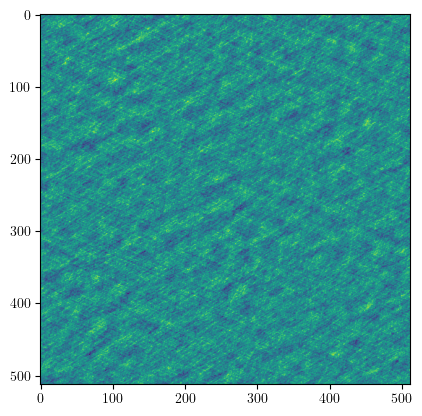

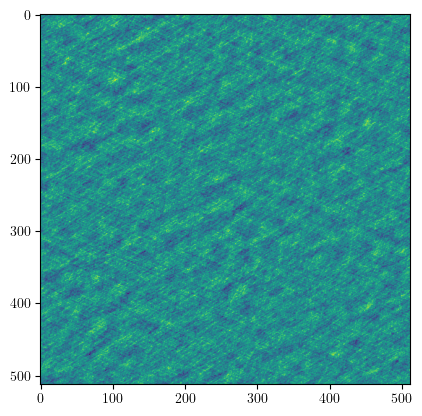

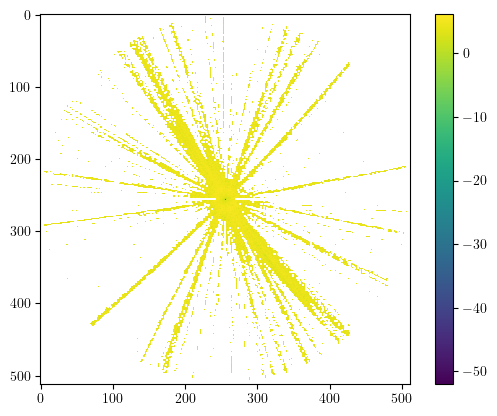

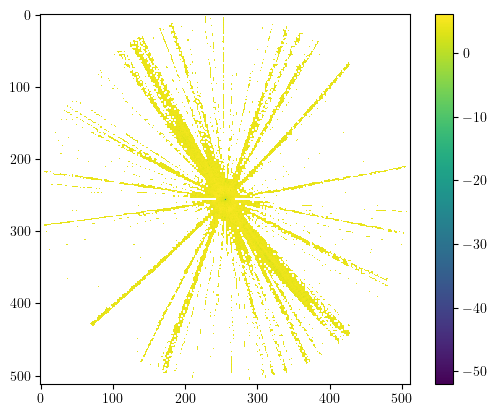

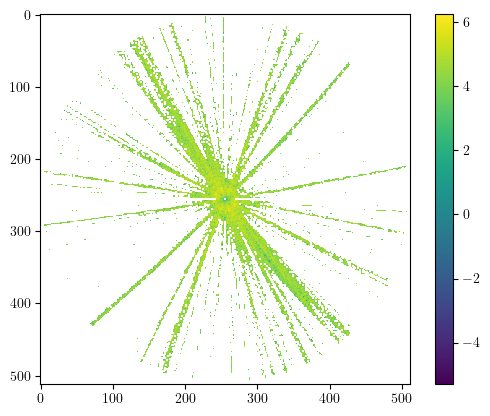

In [3]:
from jax import vjp

disc_type  = 'nearest'
f = lambda volume_real, volume_imag : ewald_sphere_forward_model(volume_real, volume_imag, rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size, lam, disc_type)
y, u = vjp(f,volume_real, volume_imag)

z1, z2 = adjoint_ewald_sphere_forward_model(y[0], y[1], rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size, lam, disc_type = 'nearest' )

# z11, z22 = adjoint_ewald_sphere_forward_model(y[0], y[1], rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size, lam, disc_type = 'nearest' )

z11,z22 = u(y)

print(np.linalg.norm(z1 - z11) / np.linalg.norm(z1))
print(np.linalg.norm(z2 - z22) / np.linalg.norm(z2))

import matplotlib.pyplot as plt
z3 = z1 + 1j * z2
z33 = z11 + 1j * z22
plt.imshow(ftu.get_idft3(z3.reshape(volume_shape)).real.sum(axis=2))
plt.figure()
plt.imshow(ftu.get_idft3(z33.reshape(volume_shape)).real.sum(axis=2))
plt.figure()
plt.imshow(np.log10(np.abs(z1) ).reshape(volume_shape)[:,:,grid_size//2])#.real.sum(axis=2))
plt.colorbar()
plt.figure()
plt.imshow(np.log10(np.abs(z2) ).reshape(volume_shape)[:,:,grid_size//2])#.real.sum(axis=2))
plt.colorbar()
plt.figure()
plt.imshow(np.log10(np.abs(z1 - z2)).reshape(volume_shape)[:,:,grid_size//2])#.real.sum(axis=2))
plt.colorbar()

In [4]:
@jax.jit
def test(volume_real):
    y = ewald_sphere_forward_model(volume_real, volume_imag, rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size, lam, disc_type)
    z1, z2 = adjoint_ewald_sphere_forward_model(y[0], y[1], rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size, lam )
    return y[0]

@jax.jit
def test2(volume_real):
    f = lambda volume_real, volume_imag : ewald_sphere_forward_model(volume_real, volume_imag, rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size, lam, disc_type = 'nearest' )
    y, u = vjp(f,volume_real, volume_imag)
    z11,z22 = u(y)
    return z11

# import functools
# @functools.partial(jax.jit, static_argnums=[4,5,6,7,8])
def compute_A_t_Av_ewald_sphere_forward_model(volume_real, volume_imag, rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size, lam, disc_type = 'nearest' ):    
    f = lambda volume_real, volume_imag : ewald_sphere_forward_model(volume_real, volume_imag, rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size, lam, disc_type = 'nearest' )
    y, u = vjp(f,volume_real, volume_imag)
    return u(y)

@jax.jit
def test3(volume_real):
    z1 , z2 = compute_A_t_Av_ewald_sphere_forward_model(volume_real, volume_imag, rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size, lam, disc_type = 'nearest' )
    return z1

# Timing comparison
%timeit test(volume_real).block_until_ready()
%timeit test2(volume_real).block_until_ready()
%timeit test3(volume_real).block_until_ready()

TypeError: adjoint_ewald_sphere_forward_model() missing 1 required positional argument: 'disc_type'

In [ ]:
reload(core)
@jax.jit
def test(volume_real):
    # get_slices_nomap(volume, rotation_matrices, image_shape, volume_shape, grid_size, disc_type):
    # z1, z2 = adjoint_ewald_sphere_forward_model(y[0], y[1], rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size, lam )
    return core.get_slices_nomap(volume_real, rotation_matrices, image_shape, volume_shape, grid_size, disc_type)

@jax.jit
def test2(volume_real):
    return core.get_slices(volume_real, rotation_matrices, image_shape, volume_shape, grid_size, disc_type)

# Timing comparison
%timeit test(volume_real).block_until_ready()
%timeit test2(volume_real).block_until_ready()




In [16]:
## ONE TEST THAT THE ADJOINT IS CORRECT

y_inp = np.concatenate([volume_real, volume_imag], axis=-1)
A_y_inp = ewald_sphere_forward_model(volume_real, volume_imag, rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size, lam, 'nearest' )
A_y_inp_vec = np.concatenate(A_y_inp, axis=-1).reshape(-1)#[0]

x = A_y_inp
im_mask = mask.get_radial_mask(tuple(2*[grid_size])).reshape(-1)
test_x = [ np.random.randn(*x[0].shape) * im_mask, np.random.randn(*x[1].shape)* im_mask]
test_x_vec = np.concatenate(test_x, axis=-1).reshape(-1).astype(np.float32)

At_test_x = adjoint_ewald_sphere_forward_model(test_x[0], test_x[1], rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size, lam, 'nearest' )
At_test_x_vec = np.concatenate(At_test_x, axis=-1)

# If adjoint is correct, then < x , Ay > === < A^T x, y >
print('rel error: ', np.abs(np.dot(test_x_vec, A_y_inp_vec) - np.dot(At_test_x_vec, y_inp)) / np.abs(np.dot(At_test_x_vec, y_inp)))

rel error:  2.8655921852629023e-08


In [17]:
# Another test that ewald == plane whenever the wavelength is tiny 
# y_inp = np.concatenate([volume_real, volume_imag], axis=-1)
big_lam = lam * 1e-24
disc_type = 'nearest' 
A_y_inp = ewald_sphere_forward_model(volume_real, volume_imag, rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size, big_lam, disc_type )
A_y_2 = A_y_inp[0] + A_y_inp[1] * 1j

CTF_fun = core.compute_ctf_cryodgrn_wrapper
A_y_inp = 2*covariance_core.get_projected_image(vol.reshape(-1), ctf_params, rotation_matrices, image_shape, volume_shape, grid_size, voxel_size, CTF_fun ,disc_type)

## FOR SOME REASON I FORGOT, THERE IS A FACTOR OF 2 THERE
print('rel error: ', np.linalg.norm( A_y_2 - A_y_inp) / np.linalg.norm(A_y_2))


rel error:  1.7276289544253092e-14


In [18]:
import matplotlib.pyplot as plt
im1 = ftu.get_idft2(A_y_2.reshape(image_shape))
plt.imshow(im1.real);  plt.colorbar()
im2 = ftu.get_idft2((A_y_inp).reshape(image_shape))
plt.figure()
plt.imshow(im2.real);  plt.colorbar()
im3 = ftu.get_idft2((A_y_inp -  A_y_2).reshape(image_shape))
plt.figure()
plt.imshow(im3.real); plt.colorbar()

TypeError: reshape total size must be unchanged, got new_sizes (512, 512) for shape (200, 262144).

In [15]:
import matplotlib.pyplot as plt
im1 = np.abs(A_y_2.reshape(image_shape))
plt.imshow(im1.real);  plt.colorbar()
im2 = np.abs((A_y_inp).reshape(image_shape))
plt.figure()
plt.imshow(im2.real);  plt.colorbar()
im3 = np.abs((A_y_inp -  A_y_2).reshape(image_shape))
plt.figure()
plt.imshow(im3.real); plt.colorbar()

TypeError: reshape total size must be unchanged, got new_sizes (512, 512) for shape (200, 262144).

In [14]:
# SOME OTHER TESTS I USED TO DEBUG..

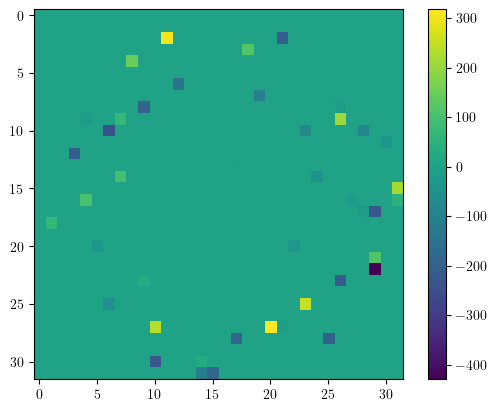

In [6]:

disc_type = 'nearest'
vol_real_on_sphere = get_ewald_sphere_slices(volume_real, rotation_matrices, image_shape, volume_shape, volume_shape[0], voxel_size, wavelength*1e0,  disc_type)
vol_plane = core.get_slices(volume_real, rotation_matrices, image_shape, volume_shape, grid_size, disc_type)

import matplotlib.pyplot as plt
plt.imshow((vol_real_on_sphere - vol_plane)[0].reshape(image_shape))
plt.colorbar()

In [7]:
sphere_coords = get_unrotated_ewald_sphere_coords(image_shape, voxel_size, lam, scaled = False)
plane_coords = core.get_unrotated_plane_grid_points(image_shape)
print(np.linalg.norm(sphere_coords - plane_coords))

2.461030057455069


In [8]:
from recovar import covariance_core
CTF_fun = core.compute_ctf_cryodgrn_wrapper
x2 = covariance_core.get_projected_image(vol.reshape(-1), ctf_params, rotation_matrices, image_shape, volume_shape, grid_size, voxel_size, CTF_fun , 'nearest')
x3 = ftu.get_idft2(x2[0].reshape(image_shape))

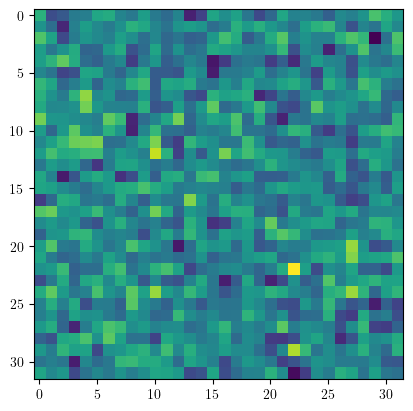

In [9]:
plt.imshow(x3.real)

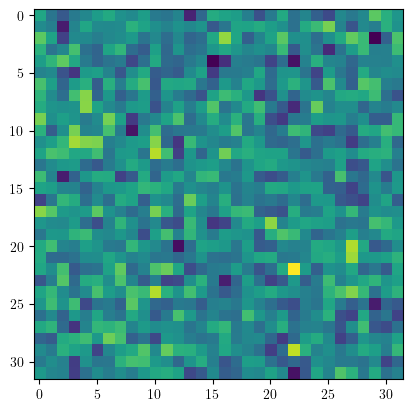

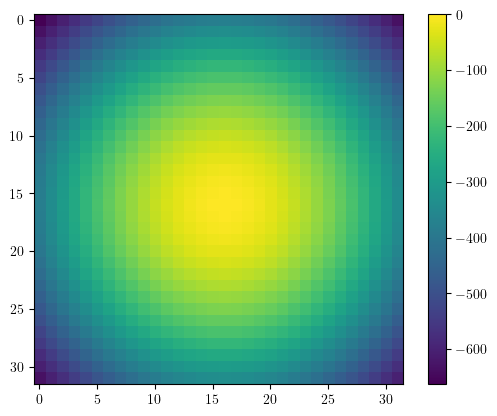

In [10]:
import matplotlib.pyplot as plt
plt.imshow(im_spatial.real)
plt.figure()
plt.imshow(chi[0].reshape(image_shape))
plt.colorbar()

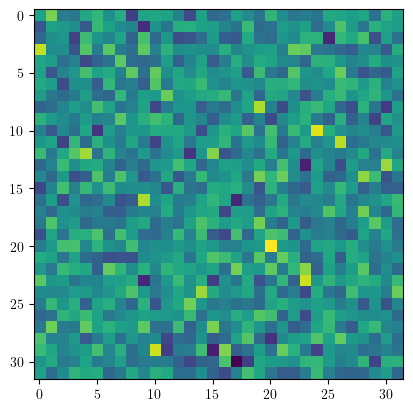

In [11]:
import matplotlib.pyplot as plt
plt.imshow(vol_spatial.reshape(volume_shape).sum(axis=0))

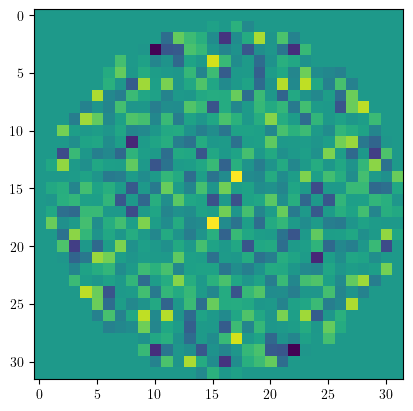

In [12]:
plt.imshow(x[0][0].reshape(image_shape).real)